In [1]:
%matplotlib inline

from collections import Counter
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import seaborn as sns

In [2]:
all_files = [fname for fname in os.listdir('data') if fname[-4:] == "json"]

In [3]:
# load all events
events = []
for i, fname in enumerate(all_files[:20]):
    if i%10 == 0:
            print i, "out of", len(all_files), "files loaded"
    for line in open(os.path.join("data", fname), 'r'):
        events.append(json.loads(line))

0 out of 504 files loaded
10 out of 504 files loaded


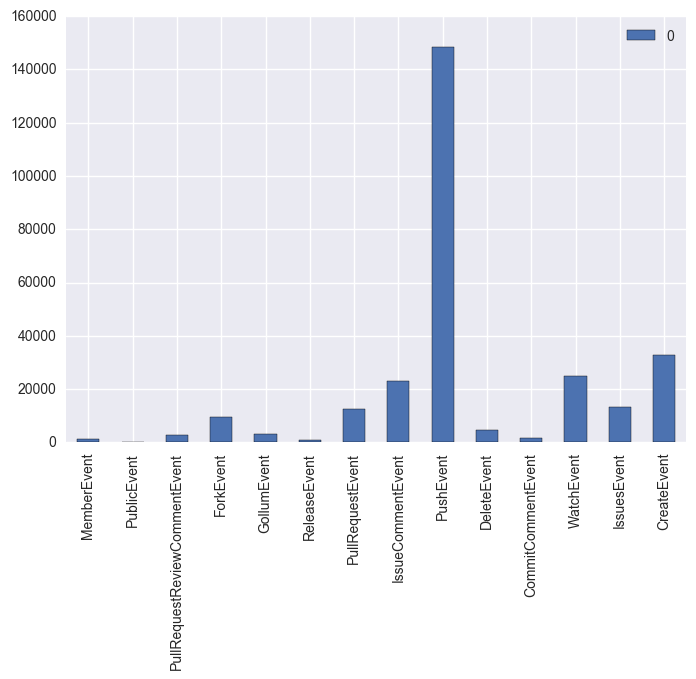

In [44]:
types = [e['type'] for e in events]
type_counts = Counter(types)
df = pd.DataFrame.from_dict(type_counts, orient='index')
df.plot(kind='bar')
plt.show()

In [5]:
actors = [e['actor']['login'] for e in events]
actor_count = Counter(actors)
over5 = np.sum([1 if v >=5 else 0 for v in actor_count.values()])
count_count = Counter(actor_count.values())

280186 75155 15582


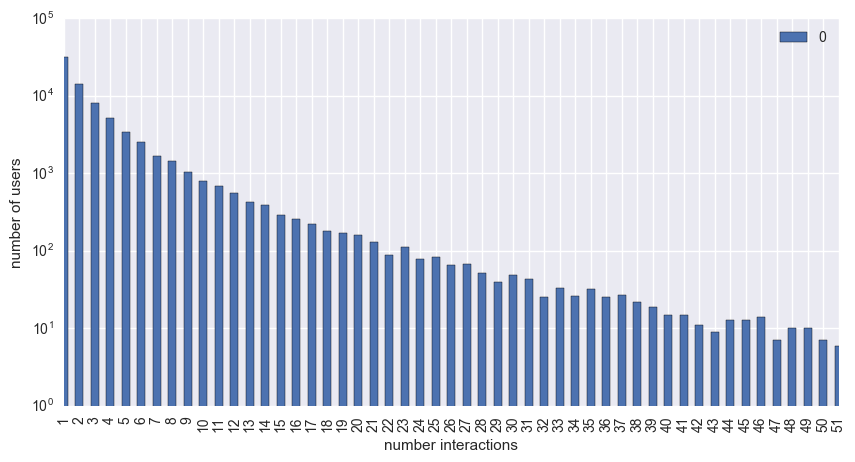

In [6]:
print len(actors), len(set(actors)), over5
df = pd.DataFrame.from_dict(count_count, orient='index')

df.plot(kind='bar', logy=True, figsize=(10,5))
plt.xlabel("number interactions")
plt.ylabel("number of users")
plt.xlim([0,50])
plt.show()

## Calculate common keys between all events

In [7]:
common_set = set(events[0].keys())
for i in range(1000):
    common_set = common_set & set(events[i].keys())
common_set

{u'actor', u'created_at', u'id', u'payload', u'public', u'repo', u'type'}

## Look into number of repos

In [8]:
repos = [e['repo']['name'] for e in events]
repo_count = Counter(repos)
df = pd.DataFrame.from_dict(repo_count, orient='index')
over5repos = np.sum([1 if v >=5 else 0 for v in repo_count.values()])
print len(repos), len(set(repos)), over5repos


280186 83777 13934


In [9]:
print len(df[df[0]>100]), "with over 100 commits in the files"
df[df[0]>100].sort_values(0, ascending=False).head(15)

71 with over 100 commits in the files


,0
KenanSulayman/heartbeat,1563
sakai-mirror/melete,600
qdm/qdm.github.io,581
dspinellis/unix-history-repo,501
rust-lang/rust,419
rdpeng/ExData_Plotting1,373
jtleek/datasharing,323
prakhar1989/awesome-courses,314
BLooperZ/blooperz.github.io,274
greatfire/wiki,250


## Repos per person

In [10]:
actor_repo = {a:set() for a in actors}

In [11]:
for e in events: 
    actor_repo[e['actor']['login']].add(e['repo']['name'])


In [12]:
a_r_count = {a:len(actor_repo[a]) for a in actors}

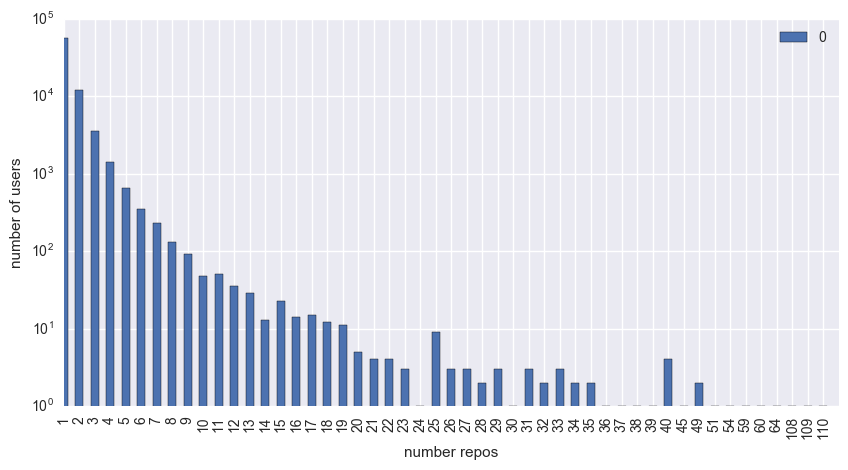

In [13]:
a_r_count_count = Counter(a_r_count.values())
df = pd.DataFrame.from_dict(a_r_count_count, orient='index')

df.plot(kind='bar', logy=True, figsize=(10,5))
plt.xlabel("number repos")
plt.ylabel("number of users")
plt.xlim([0,50])
plt.show()

## Get statistics over all data

In [28]:
# load all events
# events = []
repo_commits = Counter()
repo_users = Counter()
repo_users_names = Counter()
user_commits = Counter()

for i, fname in enumerate(all_files[:20]):
    if i%10 == 0:
            print i, "out of", len(all_files), "files loaded"
    for line in open(os.path.join("data", fname), 'r'):
        e = json.loads(line)
        if e['type'] == 'PushEvent':
            num_comms = events[0]['payload']['distinct_size']
            repo_name = e['repo']['name']
            actor_name = e['actor']['login']
            repo_commits[repo_name] += num_comms
            user_commits[actor_name] += num_comms
            if repo_users_names[repo_name]:
                repo_users_names[repo_name].add(actor_name)
            else:
                repo_users_names[repo_name] = set([actor_name])
            repo_users[repo_name] = len(repo_users_names[repo_name])
            
            #print num_comms, events[0]['payload']            
        

0 out of 504 files loaded
10 out of 504 files loaded


In [22]:
def write(outfile, dictfile):
    out = open(outfile, "w")
    items = [(v, k) for k, v in dictfile.iteritems()]
    items.sort()
    for v, k in items:
        print >> out, k, v
    out.close()

In [25]:
write("repo_commits.txt", repo_commits)
write("repo_users.txt", repo_users)
write("repo_users_names.txt", repo_users_names)


In [ ]:
import operator

In [34]:
sorted(repo_users.iteritems(), key=operator.itemgetter(1), reverse=True)[:5]

[(u'ncss-2015-group-4/trivia', 12),
 (u'Chantilly612Code/612-2015', 11),
 (u'sagemath/grant-europe', 11),
 (u'dava/dava.framework', 9),
 (u'edx/edx-platform', 9)]

In [26]:
for e in events:
    print e['payload']
    break

{u'size': 1, u'head': u'bd869e86cb714f82e9892c22ef61b3dec0123314', u'commits': [{u'distinct': True, u'sha': u'bd869e86cb714f82e9892c22ef61b3dec0123314', u'message': u'IMGs', u'url': u'https://api.github.com/repos/garethnunns/MyHRSFC-CMS/commits/bd869e86cb714f82e9892c22ef61b3dec0123314', u'author': {u'email': u'5c57adbb9b8435a23d0b23c9e09b035d6f202eb7@gmail.com', u'name': u'Gareth Nunns'}}], u'distinct_size': 1, u'push_id': 542821867, u'ref': u'refs/heads/master', u'before': u'dc7dda25564258f7e22bf3846a81a52cc909c254'}


## Simplest possible model: HMM with only user type of actions over time per repo

In [55]:
from collections import defaultdict

In [56]:
#user_take_into_account = [u for u,k in user_commits.iteritems() if k > 10]
user_last_repo = Counter()

In [45]:
etypes = set(types)
type_enc = {}
for i, v in enumerate(etypes):
    type_enc[v+"_same"] = i
typenum = len(etypes)
for i, v in enumerate(etypes):
    type_enc[v+"_diff"] = i + typenum


In [57]:
#dataset = {u:[] for u in user_take_into_account}
dataset = defaultdict(list)

In [61]:
for i, fname in enumerate(all_files):#[:20]):
    if i%10 == 0:
            print i, "out of", len(all_files), "files loaded"
    for line in open(os.path.join("data", fname), 'r'):
        e = json.loads(line)
        actor_name = e['actor']['login']
        #if actor_name in user_take_into_account:
        ctype = e['type']
        repo_name = e['repo']['name']
        suffix = ""
        if user_last_repo[actor_name] == repo_name:
            suffix = "_same"
        else: 
            suffix = "_diff"
        user_last_repo[actor_name] = repo_name
        dataset[actor_name].append(type_enc[ctype+suffix])

0 out of 504 files loaded
10 out of 504 files loaded
20 out of 504 files loaded
30 out of 504 files loaded
40 out of 504 files loaded
50 out of 504 files loaded
60 out of 504 files loaded
70 out of 504 files loaded
80 out of 504 files loaded
90 out of 504 files loaded
100 out of 504 files loaded
110 out of 504 files loaded
120 out of 504 files loaded
130 out of 504 files loaded
140 out of 504 files loaded
150 out of 504 files loaded
160 out of 504 files loaded
170 out of 504 files loaded
180 out of 504 files loaded
190 out of 504 files loaded
200 out of 504 files loaded
210 out of 504 files loaded
220 out of 504 files loaded
230 out of 504 files loaded
240 out of 504 files loaded
250 out of 504 files loaded
260 out of 504 files loaded
270 out of 504 files loaded
280 out of 504 files loaded
290 out of 504 files loaded
300 out of 504 files loaded
310 out of 504 files loaded
320 out of 504 files loaded
330 out of 504 files loaded
340 out of 504 files loaded
350 out of 504 files loaded
360

In [63]:
dataset['aszanto9']

[]

In [64]:
import cPickle as p

In [ ]:
with open('dataset.pkl', 'wb') as f:
    

In [65]:
data_lengths = [len(v) for v in dataset.values()]

KeyboardInterrupt: 

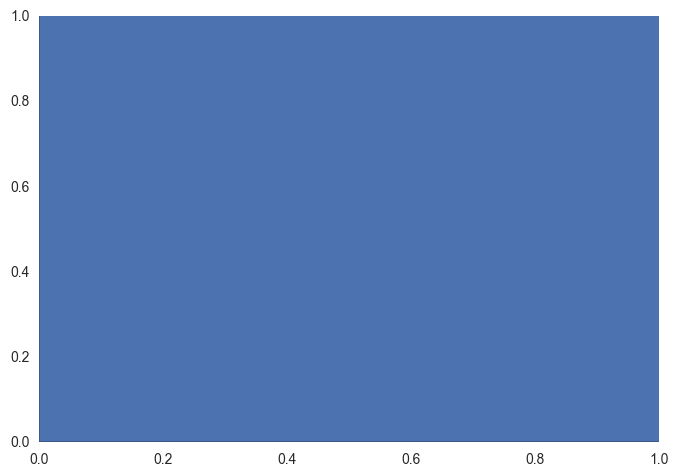

In [70]:
plt.hist(data_lengths, bins=10000)
plt.xlim([0,150])